In [2]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv("amazonreviews.tsv", sep="\t")

In [4]:
# Display shape and sample data
print(df.shape)
df.head()

(10000, 2)


,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [5]:
df.isnull().sum()

label     0
review    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
# Standardize labels
df['label'] = df['label'].str.strip().str.lower()
df = df[df['label'].isin(['pos', 'neg'])]

print(df['label'].value_counts())

label
neg    5097
pos    4903
Name: count, dtype: int64


In [8]:
# Step 3: Preprocess text
stopwords = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = [w for w in text.split() if w not in stopwords]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()

,review,clean_review
0,Stuning even for the non-gamer: This sound tra...,stuning non gamer sound track beautiful paints...
1,The best soundtrack ever to anything.: I'm rea...,best soundtrack m reading lot reviews saying b...
2,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hands i...
3,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing ve played game...


In [9]:
# Step 4: Explore the dataset
print(df['label'].value_counts())

label
neg    5097
pos    4903
Name: count, dtype: int64


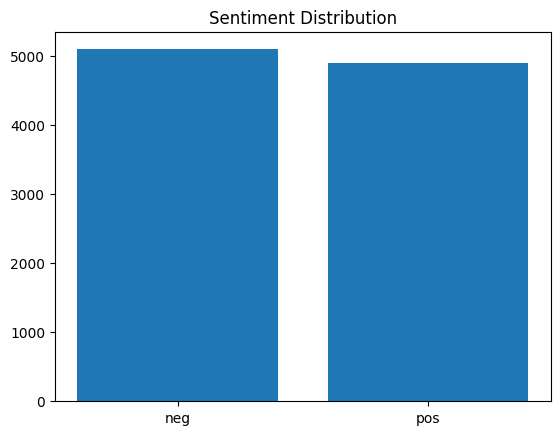

In [10]:
# Distribution of sentiments
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values)
plt.title("Sentiment Distribution")
plt.show()

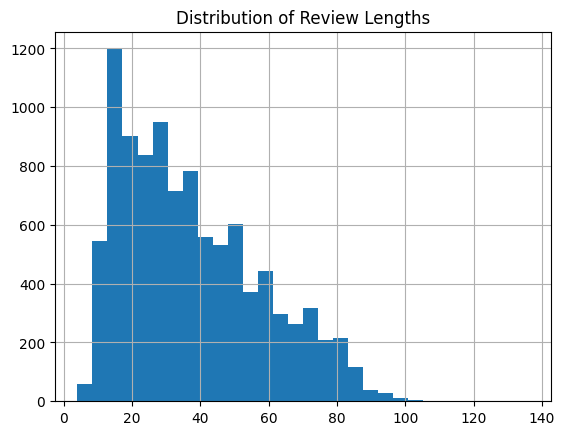

In [11]:
# Review lengths
df['length'] = df['clean_review'].apply(lambda x: len(x.split()))
df['length'].hist(bins=30)
plt.title("Distribution of Review Lengths")
plt.show()

In [12]:
# Step 5: Convert text to numerical features
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_review'])
y = (df['label'] == 'pos').astype(int)

print("Shape of features:", X.shape)

Shape of features: (10000, 20000)


In [13]:
# Step 6: Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (8000, 20000) Test size: (2000, 20000)


#### Model 1 — Logistic Regression

In [14]:
# Step 7: Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=['neg', 'pos']))

Logistic Regression Accuracy: 0.8545
F1 Score: 0.8499226405363589
              precision    recall  f1-score   support

         neg       0.85      0.87      0.86      1019
         pos       0.86      0.84      0.85       981

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



####  Model 2 — Support Vector Machine (LinearSVC)

In [15]:
# Step 8: Train Linear SVM model
svc = LinearSVC(max_iter=2000)
svc.fit(X_train, y_train)

# Predictions
y_pred_svc = svc.predict(X_test)

# Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svc))
print("F1 Score:", f1_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc, target_names=['neg', 'pos']))

SVM Accuracy: 0.8445
F1 Score: 0.8415690269994905
              precision    recall  f1-score   support

         neg       0.85      0.85      0.85      1019
         pos       0.84      0.84      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



 Confusion Matrices

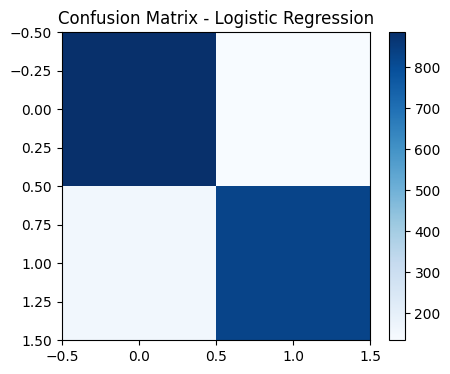

In [16]:
# Step 9: Confusion Matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_svc = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(5,4))
plt.imshow(cm_lr, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.colorbar()
plt.show()


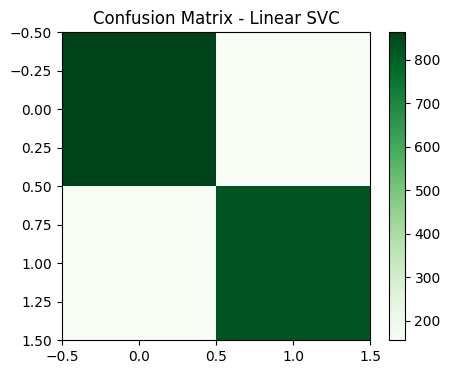

In [17]:
plt.figure(figsize=(5,4))
plt.imshow(cm_svc, cmap='Greens')
plt.title("Confusion Matrix - Linear SVC")
plt.colorbar()
plt.show()

In [18]:
# Step 10: Save models for reuse
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(log_reg, "logreg_model.joblib")
joblib.dump(svc, "svc_model.joblib")

print("Models saved successfully.")

Models saved successfully.


##### Summary

In [19]:
# Step 11: Summary Table
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVC"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svc)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_svc)
    ]
})
print(results)

                 Model  Accuracy  F1 Score
0  Logistic Regression    0.8545  0.849923
1           Linear SVC    0.8445  0.841569
